In [113]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import json
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, BRICS
from krxns.cheminfo import expand_unpaired_cofactors, mcs, draw_molecule, draw_reaction
from krxns.config import filepaths
from krxns.net_construction import SimilarityConnector, extract_compounds, fold_reactions
from krxns.utils import str2int
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
from IPython.display import display, SVG
from itertools import product
from collections import defaultdict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
def filter_cofactors(known_reactions: dict[str, dict], cofactors: dict[str, str], smi2id: dict[str, int], paired_cofactors: dict[tuple, float] = {}):
    '''
    Filters cofactors out of known reaction dict
    '''
    paired_cofactors = {tuple(sorted(k)): v for k, v in paired_cofactors.items()}

    filtered_krs = {}
    for rid, rxn in known_reactions.items():
        lhs, rhs = [set(side.split(".")) for side in rxn['smarts'].split(">>")] # Set out stoichiometric degeneracy
        lhs = [smi2id[elt] for elt in lhs if elt not in cofactors]
        rhs = [smi2id[elt] for elt in rhs if elt not in cofactors]

        if not lhs or not rhs:
            continue

        to_remove = tuple()
        best_jaccard = 0
        for pair in product(lhs, rhs):
            srt_pair = tuple(sorted(pair))

            if srt_pair in paired_cofactors and paired_cofactors[srt_pair] > best_jaccard:
                to_remove = pair # Note NOT srt pair
                best_jaccard = paired_cofactors[srt_pair]

        if to_remove:
            lhs.remove(to_remove[0])
            rhs.remove(to_remove[1])

        if len(lhs) > len(rhs):
            tmp = lhs
            lhs = rhs
            rhs = tmp

        filtered_krs[rid] = (lhs, rhs)
    
    return filtered_krs

def plot_side_counts(side_counts: dict[tuple, set]):
    x_labels, cts = zip(*sorted([(k, len(v)) for k,v in side_counts.items()], key= lambda x : x[1], reverse=True))
    x = np.arange(len(x_labels))

    fig, ax = plt.subplots()
    ax.bar(x, height=cts)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45)
    ax.set_ylabel("# reactions")
    ax.set_xlabel("(# reactants, # products)")
    plt.show()

    return fig

In [115]:
# Load known reaction data
with open(filepaths['data'] / 'sprhea_240310_v3_mapped.json', 'r') as f:
    known_reactions = json.load(f)

known_reactions = fold_reactions(known_reactions)
known_compounds, smi2id = extract_compounds(known_reactions)

# Load op connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_operator.json', 'r') as f:
    op_cxn = str2int(json.load(f))

# Load sim connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_similarity.json', 'r') as f:
    sim_cxn = str2int(json.load(f))

with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_side_counts.json', 'r') as f:
    side_counts = str2int(json.load(f))

# Compare with similarity connector

# Load unpaired cofs
unpaired_fp = filepaths['cofactors'] / "unpaired_cofactors_reference.tsv"
name_blacklist = [
    'acetyl-CoA',
]

unpaired_ref = pd.read_csv(
    filepath_or_buffer=unpaired_fp,
    sep='\t'
)

filtered_unpaired = unpaired_ref.loc[~unpaired_ref['Name'].isin(name_blacklist), :]
cofactors = expand_unpaired_cofactors(filtered_unpaired, k=10)

manual = {
    'N#N': 'N2',
    '[H][H]': 'H2',
    'S': 'hydrogen sufide',
    '[Cl-]': 'chloride',
    '[Na+]': 'sodium'
}

cofactors = {**cofactors, ** manual}

# Load cc sim mats
cc_sim_mats = {
    'mcs': np.load(filepaths['sim_mats'] / "mcs.npy"),
    'tanimoto': np.load(filepaths['sim_mats'] / "tanimoto.npy")
}

[15:58:31] WARNING: not removing hydrogen atom without neighbors


Spot check operator connected reactions

In [116]:
ocd_options = sorted(op_cxn.keys())
op_cxn_dropdown = widgets.Dropdown(options=ocd_options, value=ocd_options[0])

def show_op_cxn(rid):
    for rule in op_cxn[rid]:
        print(f"Rule: {rule}")
        print(f"Rct inlinks: {op_cxn[rid][rule]['rct_inlinks']}")
        print(f"Pdt inlinks: {op_cxn[rid][rule]['pdt_inlinks']}")
    display(SVG(draw_reaction(known_reactions[rid]['smarts'], sub_img_size=(300, 200))))

_ = interact(show_op_cxn, rid=op_cxn_dropdown)

interactive(children=(Dropdown(description='rid', options=(0, 1, 5, 6, 7, 9, 10, 13, 14, 16, 17, 20, 21, 24, 2…

Spot check similarity connected reactions

In [117]:
scd_options = list(sim_cxn.keys())
sim_cxn_dropdown = widgets.Dropdown(options=scd_options, value=scd_options[0])

def show_sim_cxn(rid):
    translate = lambda x : {known_compounds[outer]['name']: {known_compounds[inner]['name']: inner_v  for inner, inner_v in outer_v.items()} for outer, outer_v in x.items()}
    rct_inlinks = translate(sim_cxn[rid]['rct_inlinks'])
    pdt_inlinks = translate(sim_cxn[rid]['pdt_inlinks'])
    print("Rct inlinks")
    for k, v in rct_inlinks.items():
        print(k, v)
    print("\nPdt inlinks")
    for k, v in pdt_inlinks.items():
        print(k, v)
    display(SVG(draw_reaction(known_reactions[rid]['smarts'], sub_img_size=(300, 200))))

_ = interact(show_sim_cxn, rid=sim_cxn_dropdown)

interactive(children=(Dropdown(description='rid', options=(1123, 740, 7946, 10239, 12221, 13772, 6566, 14312, …

Look at multiply mapped reactions

In [118]:
multiple_imt = {k: v for k, v in op_cxn.items() if len(v) > 1}
print(len(multiple_imt))
mimt_opts = sorted(multiple_imt.keys())
mimt_dropdown = widgets.Dropdown(options=mimt_opts, value=mimt_opts[0])

def show_both(rid):
    print("SIM CONNECTED")
    translate = lambda x : {known_compounds[outer]['name']: {known_compounds[inner]['name']: inner_v  for inner, inner_v in outer_v.items()} for outer, outer_v in x.items()}
    rct_inlinks = translate(sim_cxn[rid]['rct_inlinks'])
    pdt_inlinks = translate(sim_cxn[rid]['pdt_inlinks'])
    print("Rct inlinks")
    for k, v in rct_inlinks.items():
        print(k, v)
    print("\nPdt inlinks")
    for k, v in pdt_inlinks.items():
        print(k, v)

    print("\nOP CONNECTED")
    for rule in op_cxn[rid]:
        print(f"Rule: {rule}")
        print(f"Rct inlinks: {op_cxn[rid][rule]['rct_inlinks']}")
        print(f"Pdt inlinks: {op_cxn[rid][rule]['pdt_inlinks']}")

    display(SVG(draw_reaction(known_reactions[rid]['smarts'], sub_img_size=(300, 200))))

_ = interact(show_both, rid=mimt_dropdown)

246


interactive(children=(Dropdown(description='rid', options=(9, 59, 368, 425, 489, 746, 749, 838, 943, 990, 1199…

The two cells below show:
1. Most of the multiply mapped reactions are exactly or directionally the same so can resolve easily by picking one
2. Those that are coming up as different seem to have to do with water, ambiguity around pentacovalent intermediates / situations with phosphates, and so would go away if I first converted to compound IDs, removing unpaired cofactors along the way

In [119]:
bad_rids = []

for rid in mimt_opts:
    exactly_same = True
    directionally_same = True

    full_side_count = set()
    for rule in op_cxn[rid]:
        nrcts = len(op_cxn[rid][rule]['rct_inlinks'])
        npdts = len(op_cxn[rid][rule]['pdt_inlinks'])
        full_side_count.add((nrcts, npdts))

    if len(full_side_count) > 1:
        raise ValueError("Number of substrates not consistent")

    rct_inlinks_check = defaultdict(set)
    pdt_inlinks_check = defaultdict(set)
    for rule in op_cxn[rid]:
        for side in op_cxn[rid][rule]:
            for i in op_cxn[rid][rule][side]:
                for j in op_cxn[rid][rule][side][i]:
                    if side == 'rct_inlinks':
                        rct_inlinks_check[(i, j)].add(op_cxn[rid][rule][side][i][j])
                    elif side == 'pdt_inlinks':
                        pdt_inlinks_check[(i, j)].add(op_cxn[rid][rule][side][i][j])

    if exactly_same:
        for v in rct_inlinks_check.values():
            if len(v) > 1:
                exactly_same = False
                break

    if exactly_same:
        for v in pdt_inlinks_check.values():
            if len(v) > 1:
                exactly_same = False
                break

    print(f"exactly_same: {exactly_same}")

    if not exactly_same:
        rct_inlinks_check = defaultdict(set)
        pdt_inlinks_check = defaultdict(set)
        for rule in op_cxn[rid]:
            for side in op_cxn[rid][rule]:
                for i in op_cxn[rid][rule][side]:
                    distro = list(op_cxn[rid][rule][side][i].values())
                    if side == 'rct_inlinks':
                        rct_inlinks_check[i].add(np.argmax(distro))
                    elif side == 'pdt_inlinks':
                        pdt_inlinks_check[i].add(np.argmax(distro))

        if directionally_same:
            for v in rct_inlinks_check.values():
                if len(v) > 1:
                    directionally_same = False
                    break

        if directionally_same:
            for v in pdt_inlinks_check.values():
                if len(v) > 1:
                    directionally_same = False
                    break

        print(f"Directionally same: {directionally_same}")

    if not exactly_same and not directionally_same:
        bad_rids.append(rid)

exactly_same: True
exactly_same: True
exactly_same: False
Directionally same: False
exactly_same: False
Directionally same: False
exactly_same: False
Directionally same: False
exactly_same: True
exactly_same: True
exactly_same: False
Directionally same: False
exactly_same: True
exactly_same: False
Directionally same: False
exactly_same: True
exactly_same: False
Directionally same: False
exactly_same: True
exactly_same: True
exactly_same: True
exactly_same: True
exactly_same: False
Directionally same: False
exactly_same: False
Directionally same: False
exactly_same: True
exactly_same: True
exactly_same: True
exactly_same: False
Directionally same: False
exactly_same: True
exactly_same: True
exactly_same: False
Directionally same: False
exactly_same: True
exactly_same: True
exactly_same: True
exactly_same: False
Directionally same: False
exactly_same: False
Directionally same: False
exactly_same: True
exactly_same: True
exactly_same: True
exactly_same: True
exactly_same: False
Directiona

In [120]:
bad_opts = sorted(bad_rids)
bad_dropdown = widgets.Dropdown(options=bad_opts, value=bad_opts[0])
_ = interact(show_both, rid=bad_dropdown)

interactive(children=(Dropdown(description='rid', options=(368, 425, 489, 838, 990, 1290, 1475, 1589, 2090, 23…

Spot check reactions with only similarity based connection

In [121]:
sim_only = {k: v for k, v in sim_cxn.items() if tuple(side_counts[k]) == (2, 2) and k not in op_cxn}
print(len(sim_only))
sim_only_opts = sorted(sim_only.keys())
sim_only_dropdown = widgets.Dropdown(options=sim_only_opts, value=sim_only_opts[0])

_ = interact(show_sim_cxn, rid=sim_only_dropdown)

624


interactive(children=(Dropdown(description='rid', options=(2, 26, 40, 44, 77, 80, 88, 93, 107, 110, 113, 134, …

Histogram of number of reactants / product for reactions I could not map

/home/stef/krxns/krxns/net_construction.py:309: RuntimeWarning: invalid value encountered in divide
  


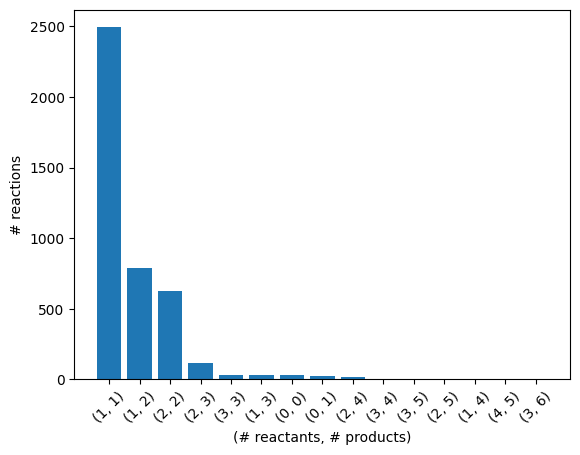

In [122]:
sc = SimilarityConnector(
    reactions=known_reactions,
    cc_sim_mats=cc_sim_mats,
    cofactors=cofactors,
    k_paired_cofactors=21,
)
smi2id = sc.smi2id
paired_cofactors = {pair: sc.cc_sim_mats['jaccard'][pair] for pair in sc.paired_cofactors}
missed_by_op = {k: v for k, v in known_reactions.items() if k not in op_cxn}

filtered_krs = filter_cofactors(missed_by_op, cofactors, smi2id, paired_cofactors)
side_counts = defaultdict(set)
for rid, (lhs, rhs) in filtered_krs.items():
    side_counts[tuple(sorted([len(x) for x in [lhs, rhs]]))].add(rid)

len(op_cxn)
new = plot_side_counts(side_counts)

In [123]:
trivial_cases = [k for k in side_counts if 1 in k]
sum([len(side_counts[k]) for k in trivial_cases])

3337

Check for degeneracy when I translate operator-connected rct/pdt-idx-based adjacency matrices to compound-id-based

In [124]:
corner_cases = {}
for rid, rule_dict in op_cxn.items():
    smiles = [elt.split('.') for elt in known_reactions[rid]['smarts'].split('>>')]
    for rule, side_dict in rule_dict.items():
        for side_idx,  (side, outer_dict) in enumerate(side_dict.items()):
            

            tmp = defaultdict(set)
            for i, inner_dict in outer_dict.items():
                ismi = smiles[side_idx ^ 0][i]
                
                if ismi in cofactors:
                    continue
                iid = smi2id[ismi]
                
                for j, weight in inner_dict.items():
                    jsmi = smiles[side_idx ^ 1][j]
                    
                    if jsmi in cofactors:
                        continue

                    jid = smi2id[jsmi]
                    tmp[(iid, jid)].add(weight)

            for k, v in tmp.items():
                if len(v) > 1:
                    corner_cases[(rid, rule, side, iid, jid)] = v

In [125]:
rids, rules, sides, iids, jids = zip(*corner_cases.keys())

cc_options = sorted(set(rids))
cc_dropdown = widgets.Dropdown(options=cc_options, value=cc_options[0])

_ = interact(show_both, rid=cc_options)

interactive(children=(Dropdown(description='rid', options=(159, 268, 641, 836, 890, 912, 990, 1181, 1251, 1306…

In [166]:
double_resolved = op_cxn.keys() & sim_cxn.keys()
direction_from_side = lambda side : 0 if side == 'rct_inlinks' else 1 if side == 'pdt_inlinks' else print("Error side key not found")
from krxns.net_construction import remove_cofactors, handle_multiple_rules, translate_operator_adj_mat


mismatches = {}
for rid in double_resolved:
    rules = op_cxn[rid]
    smiles = [elt.split('.') for elt in known_reactions[rid]['smarts'].split('>>')]

    # Remove unpaired cofactors
    filtered_rules = defaultdict(lambda : defaultdict(dict))
    for rule, sides in rules.items():
        for side, adj_mat in sides.items():
            direction = direction_from_side(side)
            adj_mat = remove_cofactors(adj_mat, direction, smiles, cofactors)
            filtered_rules[rule][side] = adj_mat

    sel_adj_mats = handle_multiple_rules(filtered_rules) # Resolve cases with multiple rules

    for side, adj_mat in sel_adj_mats.items():
        direction = direction_from_side(side)
        adj_mat = translate_operator_adj_mat(adj_mat, direction, smiles, smi2id)[0]
        
        for cid, op_row in adj_mat.items():
            sim_row = sim_cxn[rid][side][cid]
            op_max_neighbor = sorted(op_row, key=lambda x : op_row[x], reverse=True)[0]
            sim_max_neighbor = sorted(sim_row, key=lambda x : sim_row[x], reverse=True)[0]
            if op_max_neighbor != sim_max_neighbor:
                mismatches[rid] = (adj_mat, sim_cxn[rid][side], side) # (operator, similarity, side)

In [167]:
len(mismatches), len(double_resolved), len(mismatches) / len(double_resolved)

(798, 5610, 0.14224598930481283)

In [172]:
opts = sorted(mismatches.keys())
dd = widgets.Dropdown(options=opts, value=opts[0])

@interact
def compare_op_sim(rid = dd):
    translate = lambda x : {known_compounds[outer]['name']: {known_compounds[inner]['name']: inner_v  for inner, inner_v in outer_v.items()} for outer, outer_v in x.items()}
    labels = ("Operator", "Similarity")
    print(rid, known_reactions[rid]['imt_rules'], mismatches[rid][-1])
    display(SVG(draw_reaction(known_reactions[rid]['smarts'])))
    for i, adj in enumerate(mismatches[rid][:2]):
        print(labels[i])
        adj = translate(adj)
        adj = pd.DataFrame(adj).transpose()
        display(adj)

interactive(children=(Dropdown(description='rid', options=(6, 10, 24, 45, 46, 47, 61, 81, 95, 98, 135, 140, 15…

In [174]:
for mm in mismatches:
    imt = known_reactions[mm]['imt_rules']
    imt = [elt.split('_')[0] for elt in imt]
    if 'rule0126' in imt:
        print(mm)

5088
6293
7531
9243
10216
10540
12066
14722
15237
16754


In [176]:
known_reactions[7531]['rhea_ids']

[41489]